In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from lifetimes import BetaGeoFitter
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.plotting import plot_history_alive
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases
import warnings

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('wx_user.csv')

In [3]:
df.head()

,user_id,follow_time,auth_time,createtime,order_no,paid_cash,create_date
0,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018/12/29
1,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.021012e+14,50.0,2021/1/15
2,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018110e+14,1.0,2018/11/2
3,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018122e+14,1.0,2018/12/23
4,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018121e+14,1.0,2018/12/7


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 738066 entries, 0 to 738065
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   user_id      738066 non-null  int64  
 1   follow_time  738066 non-null  object 
 2   auth_time    730518 non-null  object 
 3   createtime   738066 non-null  object 
 4   order_no     700123 non-null  float64
 5   paid_cash    700123 non-null  float64
 6   create_date  700123 non-null  object 
dtypes: float64(2), int64(1), object(4)
memory usage: 39.4+ MB


In [5]:
df.drop_duplicates(subset='order_no', inplace=True)
df.describe()

,user_id,order_no,paid_cash
count,700124.000000,7.001230e+05,700123.000000
mean,192485.010128,2.020049e+14,957.785317
std,186695.609254,1.762840e+11,3498.456584
min,2.000000,2.016052e+14,0.010000
25%,39286.000000,2.019023e+14,12.000000
50%,115615.000000,2.020111e+14,40.000000
75%,329243.000000,2.021102e+14,300.000000
max,761984.000000,2.023092e+14,460000.000000


In [6]:
df.isna().sum()

user_id          0
follow_time      0
auth_time      148
createtime       0
order_no         1
paid_cash        1
create_date      1
dtype: int64

In [7]:
#合并学习用户数据
#读取学习用户数据
df_study = pd.read_csv('customer_learning.csv')
#通过user_id进行合并
merged_dataframe = pd.merge(df, df_study, on='user_id', how='inner')
merged_dataframe.head()

,user_id,follow_time,auth_time,createtime,order_no,paid_cash,create_date,action_month,watch_minute,course,broadcast,playback
0,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018/12/29,2021-01,15.17,0,14.17,1
1,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018/12/29,2021-02,11.13,0,11.13,0
2,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018/12/29,2021-03,20.00,0,20.00,0
3,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018/12/29,2021-04,96.28,1,95.28,0
4,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018/12/29,2021-05,1.00,0,0.00,1


In [8]:
# 删除重复的订单数据
merged_dataframe.drop_duplicates(subset='order_no', inplace=True)

In [9]:
merged_dataframe['user_id'].nunique() 

64588

In [10]:
merged_dataframe.head()

,user_id,follow_time,auth_time,createtime,order_no,paid_cash,create_date,action_month,watch_minute,course,broadcast,playback
0,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018123e+14,1.0,2018/12/29,2021-01,15.17,0,14.17,1
32,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.021012e+14,50.0,2021/1/15,2021-01,15.17,0,14.17,1
64,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018110e+14,1.0,2018/11/2,2021-01,15.17,0,14.17,1
96,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018122e+14,1.0,2018/12/23,2021-01,15.17,0,14.17,1
128,2,2023/3/9 14:36:14,2014/8/3 22:39:25,2014/4/30 09:30:23,2.018121e+14,1.0,2018/12/7,2021-01,15.17,0,14.17,1


In [11]:

#筛选99+订单作为金额及消费频次统计对象,剔除渠道经销商提货（选择订单金额小于5w)
merged_dataframe = merged_dataframe[(merged_dataframe['paid_cash'] >= 99) & (merged_dataframe['paid_cash'] < 50000)]
merged_dataframe['user_id'].nunique()

54004

In [12]:
df_rfmt = summary_data_from_transaction_data(merged_dataframe,
                                             'user_id',
                                             'create_date',
                                             'paid_cash',
                                             observation_period_end='2023-10-1')

df_rfmt.head()

,frequency,recency,T,monetary_value
user_id,,,,
2,1.0,12.0,1948.0,19800.0000
6,4.0,2068.0,2209.0,149.2500
7,1.0,671.0,1605.0,213.0000
13,8.0,2358.0,2545.0,262.3750
15,8.0,2383.0,2688.0,234.5625


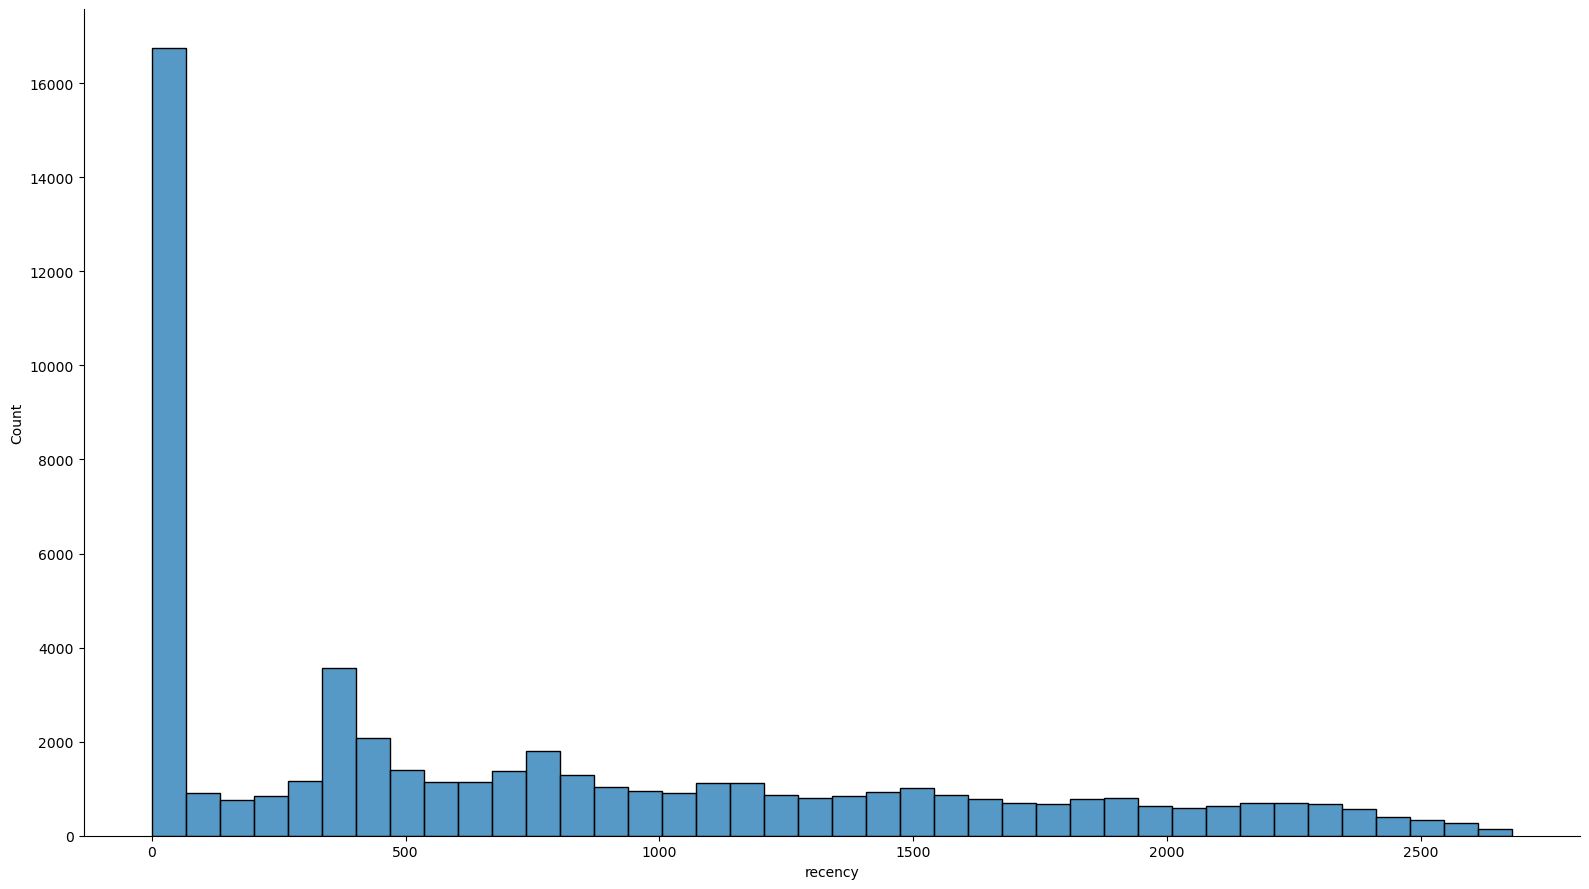

In [13]:
ax = sns.displot(df_rfmt['recency'], height=9, aspect=16/9)
plt.show()

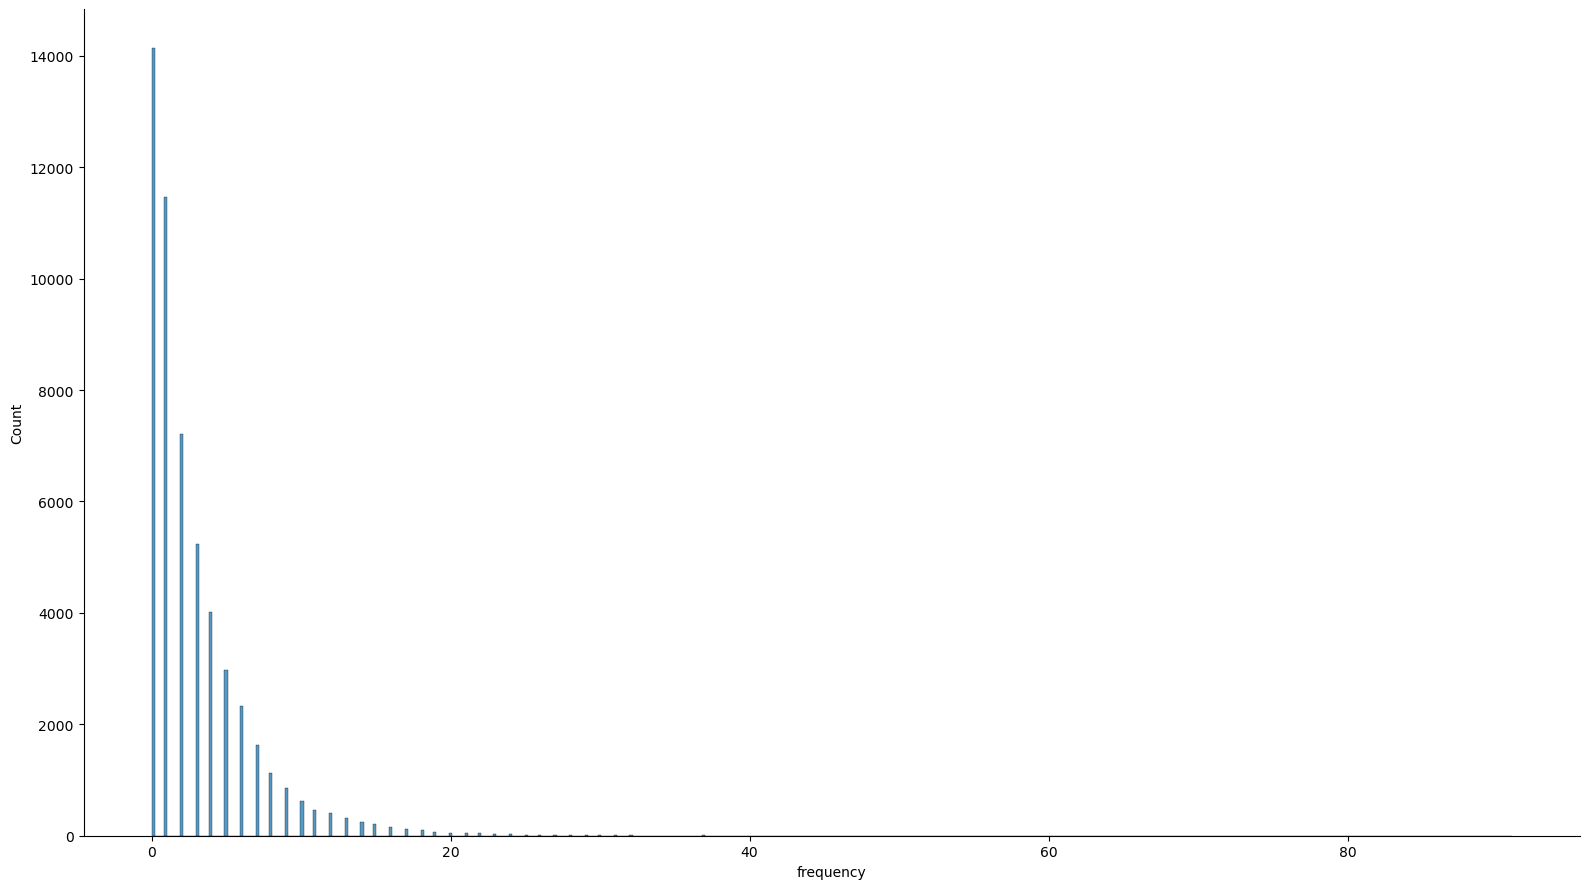

In [14]:
ax = sns.displot(df_rfmt['frequency'], height=9, aspect=16/9)
plt.show()

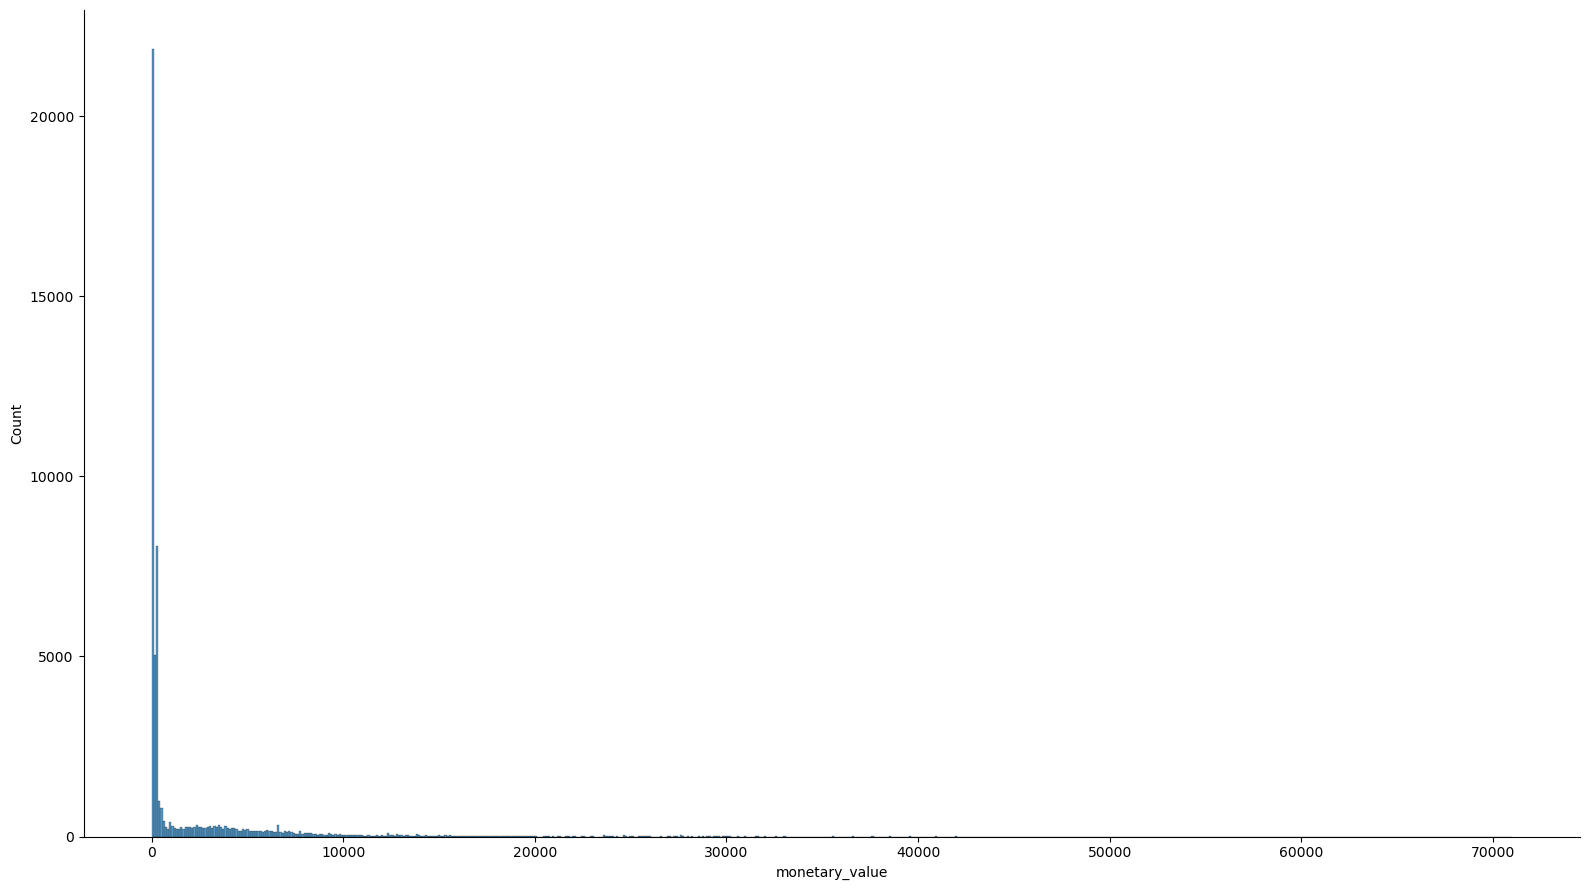

In [15]:
ax = sns.displot(df_rfmt['monetary_value'], height=9, aspect=16/9)
plt.show()

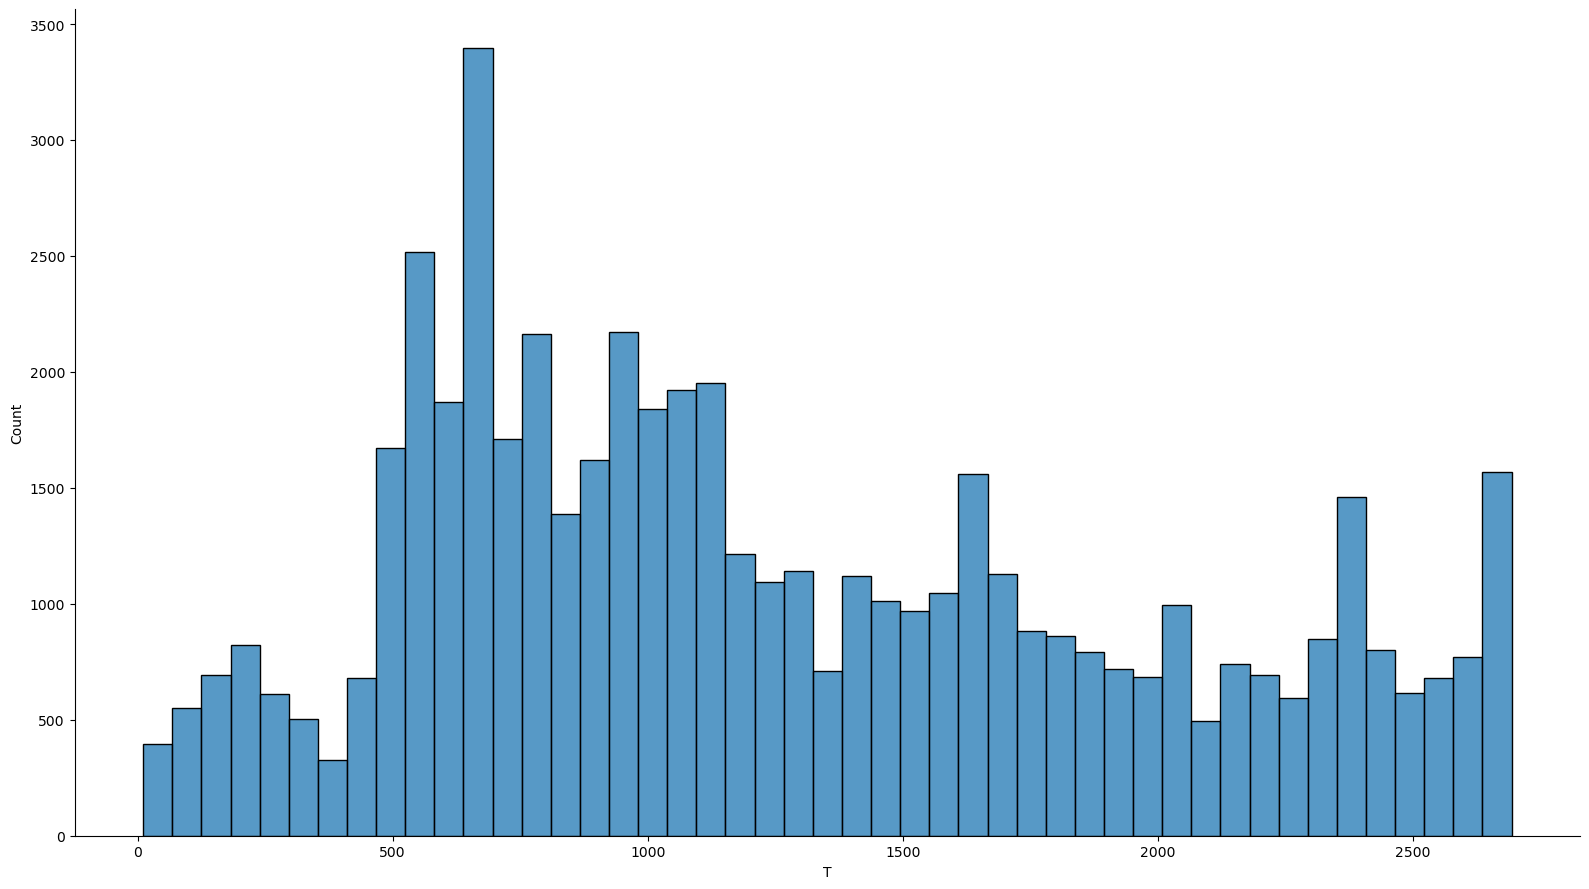

In [16]:
ax = sns.displot(df_rfmt['T'], height=9, aspect=16/9)
plt.show()

In [17]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(df_rfmt['frequency'], df_rfmt['recency'], df_rfmt['T'])
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,1.431623,0.013240,1.405673,1.457573
alpha,612.581375,6.918113,599.021874,626.140876
a,0.033297,0.002106,0.029169,0.037426
b,0.540174,0.022540,0.495996,0.584353


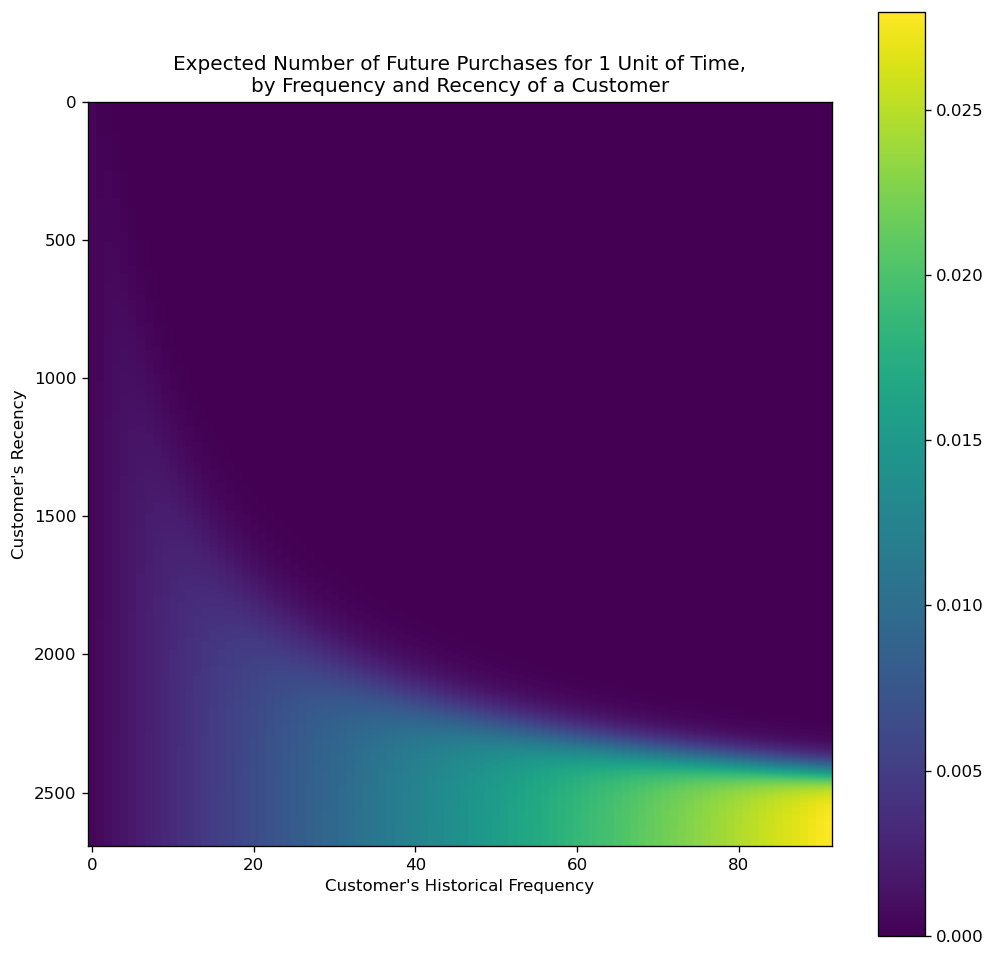

In [18]:
figure(num=None, figsize=(10, 10), dpi=120, facecolor='w', edgecolor='k' )
plot_frequency_recency_matrix(bgf)
plt.show()

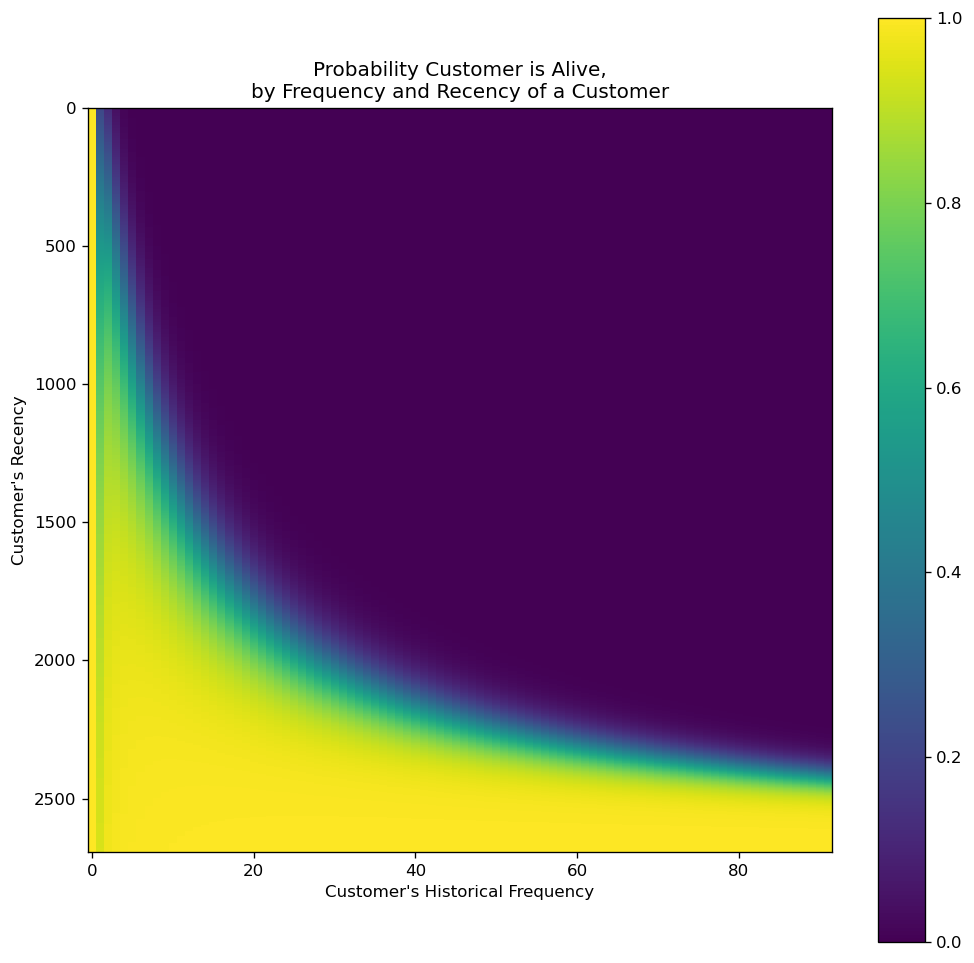

In [19]:
figure(num=None, figsize=(10, 10), dpi=120, facecolor='w', edgecolor='k' )
plot_probability_alive_matrix(bgf)
plt.show()

In [45]:
# 预测用户未来产生的订单数量

t = 360
df_rfmt['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t,
                                                                                      df_rfmt['frequency'],
                                                                                      df_rfmt['recency'],
                                                                                      df_rfmt['T'])
df_rfmt

,frequency,recency,T,monetary_value,predicted_purchases
user_id,,,,,
2,1.0,12.0,1948.0,19800.0000,0.048915
6,4.0,2068.0,2209.0,149.2500,0.741158
7,1.0,671.0,1605.0,213.0000,0.308646
13,8.0,2358.0,2545.0,262.3750,1.104929
15,8.0,2383.0,2688.0,234.5625,1.049563
...,...,...,...,...,...
760350,2.0,14.0,30.0,800.0000,1.913442
760404,1.0,18.0,30.0,25600.0000,1.364663
760815,1.0,6.0,26.0,600.0000,1.366479


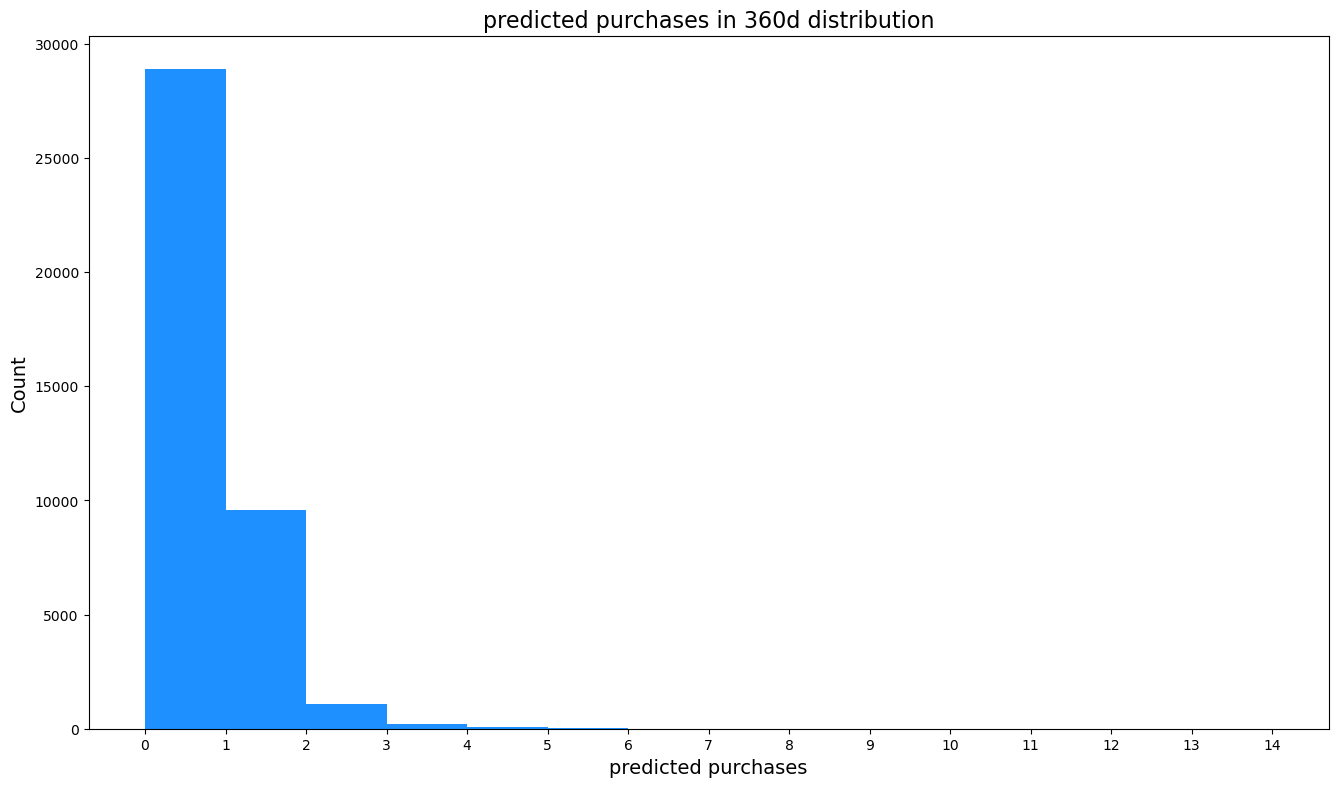

In [48]:
#图形化预测结果分布

fil = df_rfmt[df_rfmt['predicted_purchases'] >= 0]
bins = np.arange(0,  15, 1)
ticks  = np.arange(0, 15, 1)

plt.figure(figsize=(16, 9)) #定义生成图片尺寸

plt.hist(data=fil, x='predicted_purchases', bins=bins, color='dodgerblue')
plt.xticks(ticks, ticks)
plt.xlabel('predicted purchases', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('predicted purchases in 360d distribution', fontsize=16);
plt.show()

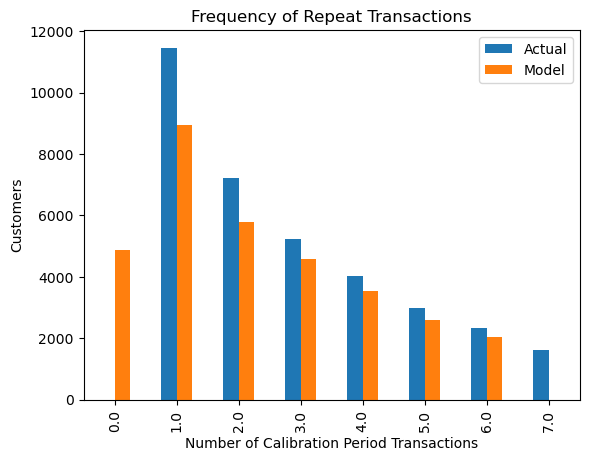

In [49]:
plot_period_transactions(bgf)
plt.show()

In [50]:
#观察周期3年，时间越长有利于模型预测的准确性
summary_cal_holdout = calibration_and_holdout_data(merged_dataframe, 
                                                   'user_id', 
                                                   'create_date',
                                                    calibration_period_end='2020-10-01',
                                                    observation_period_end='2023-10-01')

In [51]:
summary_cal_holdout.sort_values(by='frequency_holdout', ascending=False).head()

,frequency_cal,recency_cal,T_cal,frequency_holdout,duration_holdout
user_id,,,,,
1634,36.0,1253.0,1533.0,55.0,1095.0
424885,1.0,99.0,153.0,38.0,1095.0
554,0.0,0.0,4.0,35.0,1095.0
160849,7.0,576.0,589.0,31.0,1095.0
35637,7.0,991.0,1233.0,30.0,1095.0


In [52]:
bgf.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 27148 subjects, a: 0.00, alpha: 610.15, b: 0.00, r: 1.51>

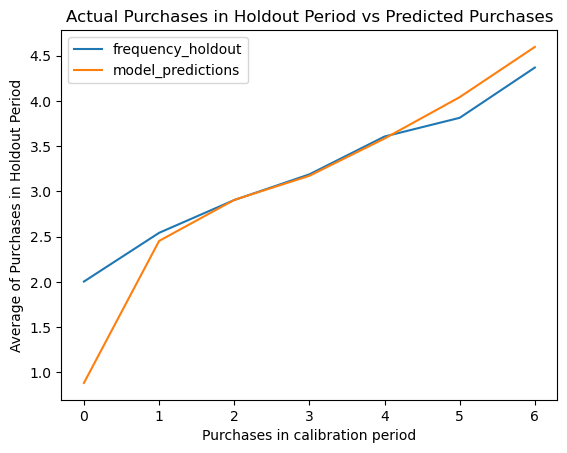

In [53]:
plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)
plt.show()

In [27]:
# Predicting customer lifetime value ，using Gamma-Gamma model
#筛选留存的用户
returning_customers = df_rfmt[ (df_rfmt['frequency'] > 0) & (df_rfmt['monetary_value'] > 0)]
returning_customers.sort_values(by='monetary_value', ascending=False).head()

,frequency,recency,T,monetary_value,predicted_purchases
user_id,,,,,
321775,1.0,250.0,1499.0,71000.000000,0.133885
425461,1.0,1.0,1251.0,60600.000000,0.122016
102589,31.0,1440.0,2075.0,58155.916452,0.277308
338589,1.0,69.0,1276.0,55200.000000,0.133157
42683,1.0,29.0,1399.0,54200.000000,0.108875


In [28]:
#检查Monetary和Frequency的相关性

returning_customers[['monetary_value', 'frequency']].corr()


,monetary_value,frequency
monetary_value,1.000000,0.025883
frequency,0.025883,1.000000


In [29]:
# 分数说明相关度符合Gamma-Gamma模型（即，用户产生的消费金额和频次是独立的
# Fit the Gamma-Gamma Model
from lifetimes import GammaGammaFitter

ggf = GammaGammaFitter(penalizer_coef = 0.01)
ggf.fit(returning_customers['frequency'],
        returning_customers['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 39872 subjects, p: 3.35, q: 0.25, v: 3.23>

In [30]:
# 使用模型预测订单的平均消费金额
predicted_monetary = ggf.conditional_expected_average_profit(
        returning_customers['frequency'],
        returning_customers['monetary_value']
)

In [31]:
# 将返回的结果展示出来，并按照从大到小顺序进行展示
aov_df = pd.DataFrame(predicted_monetary,columns = ['aov'])
aov_df = aov_df.sort_values(by='aov', ascending=False)
aov_df.head(10)

,aov
user_id,
321775,91504.512612
425461,78101.644809
338589,71142.463450
42683,69853.726161
198816,69080.483788
278118,64441.029548
45880,60832.565140
520434,60832.565140
102589,58579.392235


In [32]:
# 查看最小的后5个数据
aov_df.tail(5)

,aov
user_id,
75033,105.730102
464109,104.320938
303675,104.320938
280772,104.320938
540636,104.320938


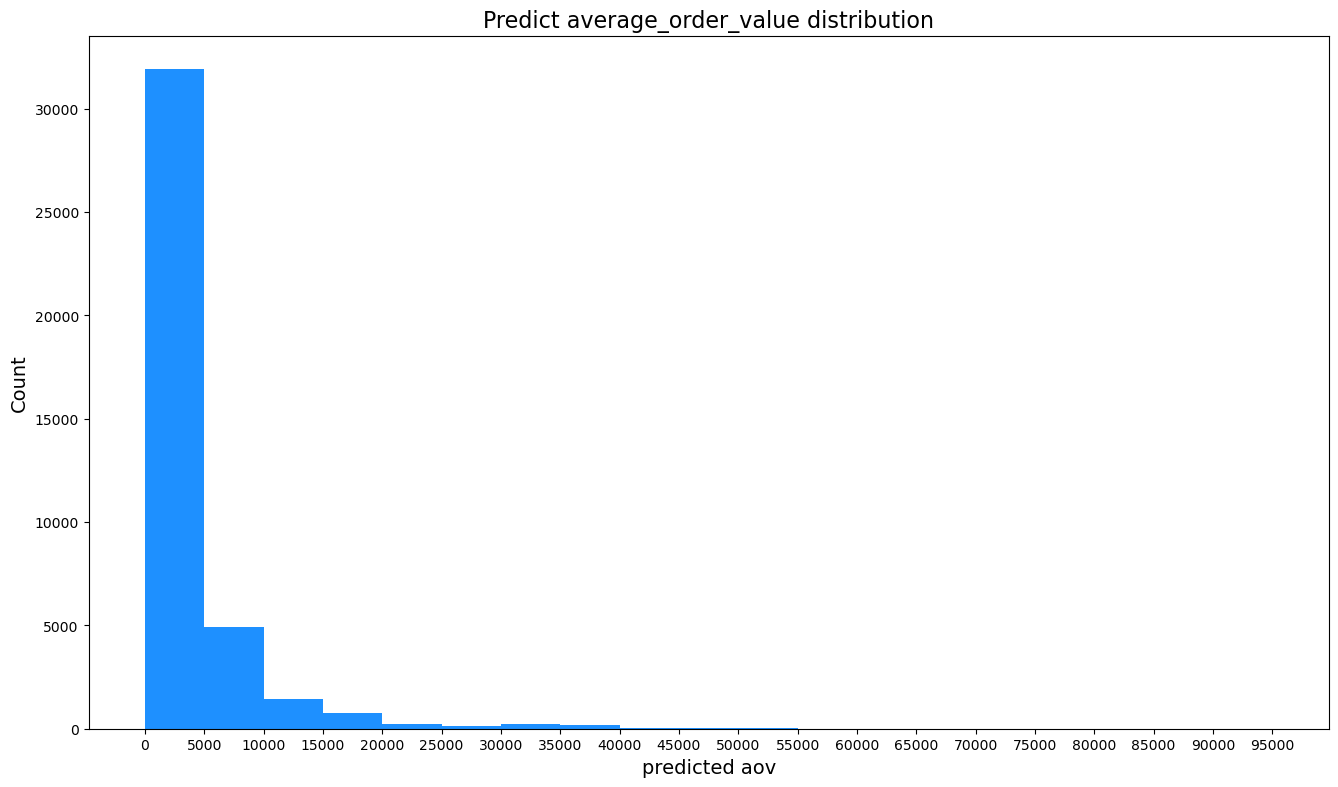

In [44]:
# 查看分布图

fil = aov_df[aov_df['aov'] >= 0]
bins = np.arange(0,  100000, 5000)
ticks  = np.arange(0, 100000, 5000)

plt.figure(figsize=(16, 9)) #定义生成图片尺寸

plt.hist(data=fil, x='aov', bins=bins, color='dodgerblue')
plt.xticks(ticks, ticks)
plt.xlabel('predicted aov', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Predict average_order_value distribution', fontsize=16);
plt.show()

In [34]:
# 预测用户的CLV：
# 使用BG/NBD 模型预测未来产生的订单数

bgf.fit(returning_customers['frequency'], 
        returning_customers['recency'], 
        returning_customers['T'])

<lifetimes.BetaGeoFitter: fitted with 39872 subjects, a: 0.09, alpha: 701.07, b: 0.75, r: 2.22>

In [55]:
#预测用户的CLV
#结合Gamma-Gamma模型预测的客单价进行计算CLV,同时现金流的折现率按照 0.01进行计算,预测未来 36个月的CLV

preds = ggf.customer_lifetime_value(
    bgf,
    returning_customers['frequency'],
    returning_customers['recency'],
    returning_customers['T'],
    returning_customers['monetary_value'],
    time = 36,
    discount_rate = 0.01
)

preds = preds.to_frame().reset_index()

preds.sort_values(by='clv', ascending=False).head() 

,user_id,clv
14640,102589,640695.827324
16973,125912,172857.155563
343,1634,159573.906041
9627,53045,156035.155711
39132,657226,124874.589614


In [62]:
# 检查一下尾部的值
preds.sort_values(by='clv', ascending=False).tail()

,user_id,clv
1263,6815,91.397681
1628,8616,91.369775
2420,12329,91.341885
2802,14523,91.314013
5581,29639,91.008536


In [63]:
#计算用户产生的总金额
preds['clv'].sum()

304480119.73473305

In [64]:
preds['clv'].describe()

count     39872.000000
mean       7636.439600
std       12250.885731
min          91.008536
25%         356.862785
50%         752.830137
75%       12237.994036
max      640695.827324
Name: clv, dtype: float64

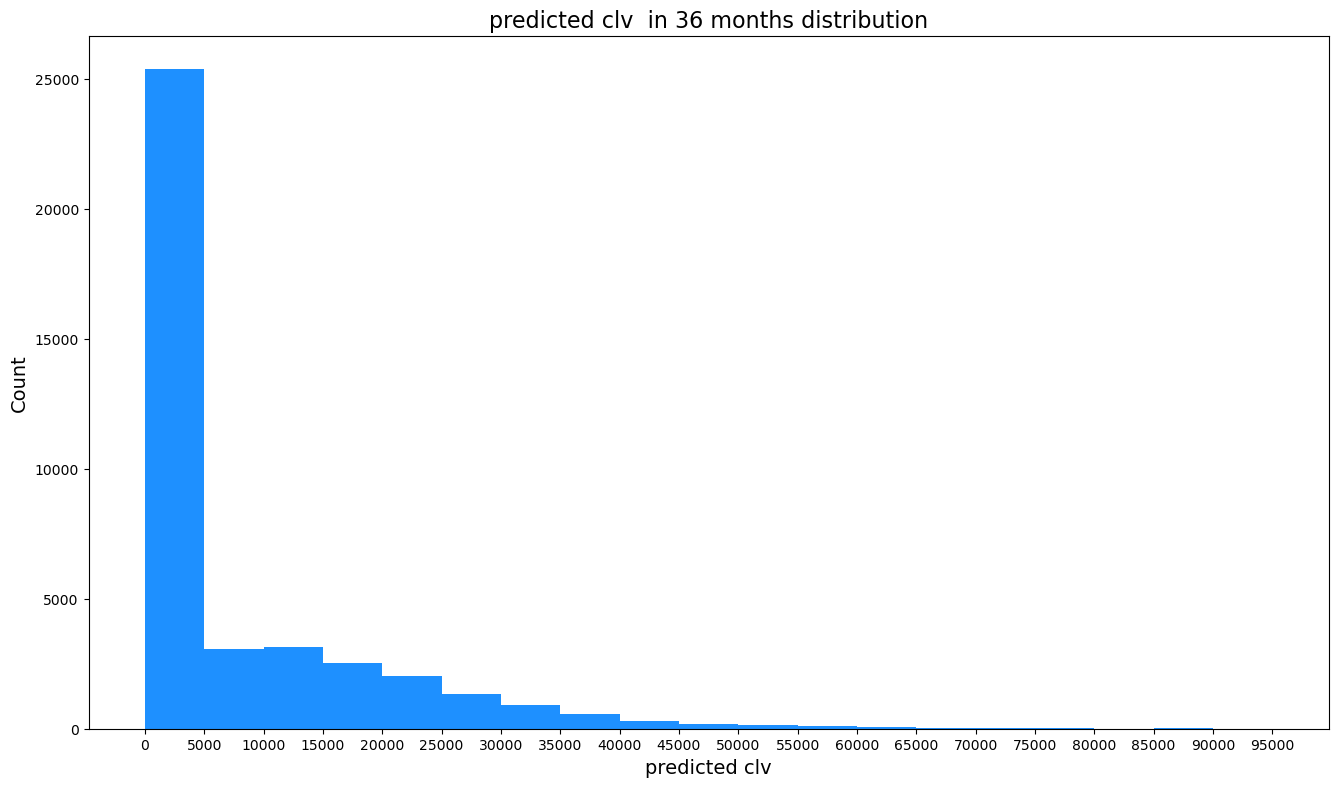

In [65]:
#查看分布
fil = preds[preds['clv'] >= 0]
bins = np.arange(0,  100000, 5000)
ticks  = np.arange(0, 100000, 5000)

plt.figure(figsize=(16, 9)) #定义生成图片尺寸

plt.hist(data=fil, x='clv', bins=bins, color='dodgerblue')
plt.xticks(ticks, ticks)
plt.xlabel('predicted clv', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('predicted clv  in 36 months distribution', fontsize=16);
plt.show()